# Data Assimilation in eWaterCycle using BMI
## Ensemble Kalman Filter example using Lorenz-96 model
The Ensemble Kalman Filter (EnKF) is a variant on the Kalman Filter when dealing with models for which it is hard to define a tangiant model. Data Assimilation methods, including all variants of the Kalman Filter Family, set to provide the (mathimatically) optimal estimation of the true state of a system, given that a (often phyiscal/physially based) model is available that can project the current state of the model into the future and that at the same time observations are available that measure (parts of) the state, either directly or indirectly.

A mathematical overview of the EnKF is given in [cite Evensen]. This notebook is intended as an introduction on how to do data assimilation within the eWaterCycle framework, with models that communicate through BMI. It is not intended as an indepth explenation of the EnKF. 

## data assimilation jargon
The following terms are often used in data assimilation:

- **ensemble** is a collection of model-instances. Often these are multiple instances of the same model where the spread in the model state represents the uncertainty in our knowledge of that model state.
- **model** a mathematical and/or computer code represenation of how the state of the system evolves in time.  
- **observation** a measurement (or set of measurements, including images)that relate to (part of) the state of the system
- **observation model** a mathematical and/or computer code representation of how the state relates to the observations. Often donated by $\mathbf{H}$.
- **forecast** The forecasted state using the model and a previous state
- **analyses** The best estimate of the state using both a forecast and an observation. The analyses (or analyses-ensemble) is the output of a data assimilation method.

In this notebook I will use a Lorenz-96 model that has been wrapped with BMI, see the 'Lorenz-96 model ensemble demonstration' notebook in this repository for an introduction into that model. I use the Ensemble Kalman Filter as data assimilation method, see [cite Evensen]. The focus of this notebook is to demonstrate how to do a data assimilation experiment where the model and the method are not part of the experiment code.

The experiment I run is a comparison of the bias of the ensemble mean versus the truth and of the spread of the ensemble over time. The Truth is generated through a model instance classified as "true" and the ensemble starts as slight modifications of this truth, which after a spin-up period, significantly deviate from the truth. The observations are direct measurements of part of the state, with added measurement noise.

The first cell loads all the needed dependencies. The final two are the model and the data assimilation method and are shared with this repository.


In [2]:
#required libraries and settings
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import io
import math

import BMILorenz
import EnKF

## settings
The settings for this experiment are split between settings for the model, for the observations and for the data assimilation method and finally for the experiment

In [3]:
##model

J = 40 #dimension of Lorenz-96 Model
commonStartState = np.zeros(J) #start-vector
commonStartState[5]=0.01

#settings data in dict for export to YAML file
settings = {'J': J,
            'F': 8.0,
            'startTime': 0.0,
            'endTime': 10.0,
            'dt':1e-3,
            'startState': commonStartState.tolist()}



##Observations
observationSigma = 0.05             #standard deviation of the observations
obsVector = range(math.floor(J/2))  #only observe half of the state
obsSize = len(obsVector);           #size of the observations vector
def H(state):                       #the "observation model" that links model-space to observation-space
    return state[obsVector]


##Ensemble Kalman Filter
N = 100                             #numeber of ensemble members, needs to be higher than dimension of the
                                    # model for stability, since no inflation is implemented.

## Experiment
spinUpTime = 3                      #time that the ensemble is run before data assimilation starts to 
updateInterval = 1                  #how often is the ensemble updated with observations

plotState = 5                       #which state of the model (both truth and ensemble) to plot
obsPlotState = 5                    #which state of the observations to plot

In [4]:
# Write YAML setting file for BMI model
with io.open('settings.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(settings, outfile, default_flow_style=False, allow_unicode=True)

In [5]:
#start with  an empty ensemble
ensemble = []


#create and initialize an instance of the BMILorenz class
truthModel = BMILorenz.BMILorenz ()
truthModel.initialize('settings.yaml')

output = pd.DataFrame(columns = ['truth','observation'])

for n in range (N):
    #add an ensemble methods
    ensemble.append(BMILorenz.BMILorenz ())
    ensemble[n].initialize('settings.yaml')
    ensemble[n].set_value_at_indices('state',5,ensemble[n].get_value_at_indices('state',5) + np.random.randn(1)*0.01)
    
    #also add a column to the output dataframe to store the output
    output['ensemble' + str(n)]= np.nan
    
 

In [6]:
#spin up the Ensemble. 

while truthModel.get_current_time()< spinUpTime:
    
    truthModel.update()
    output.loc[truthModel.get_current_time(),'truth'] = truthModel.get_value_at_indices('state',plotState)
    
    observation = truthModel.get_value('state') + observationSigma * np.random.randn(J)
    output.at[truthModel.get_current_time(),'observation'] = observation[plotState]
    
    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        output.at[ensemble[n].get_current_time(),'ensemble' + str(n)] = ensemble[n].get_value_at_indices('state',plotState)
        
    #TODO update observation on bases of observation
    
    #TODO track statistics metrics
    
updateTime = spinUpTime


In [7]:
#run 

foreCastEnsemble = np.zeros([J,N])
observationEnsemble = np.zeros([obsSize,N])

while truthModel.get_current_time()<truthModel.get_end_time():
    truthModel.update()
    output.loc[truthModel.get_current_time(),'truth'] = truthModel.get_value_at_indices('state',plotState)
    
    observation = H(truthModel.get_value('state')) + observationSigma * np.random.randn(obsSize)
    output.at[truthModel.get_current_time(),'observation'] = observation[plotState]
    
    

    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        foreCastEnsemble[:,n] = ensemble[n].get_value('state')
        observationEnsemble[:,n] = observation + observationSigma*np.random.randn(obsSize)
        output.at[ensemble[n].get_current_time(),'ensemble' + str(n)] = ensemble[n].get_value_at_indices('state',plotState)
        
    #TODO update ensemble on bases of observation
    if truthModel.get_current_time() > updateTime:
        updateTime = updateTime + updateInterval
        analysesEnsemble = EnKF.EnKF(foreCastEnsemble,observationEnsemble,H)
        np.clip(analysesEnsemble, -10, 20, out=analysesEnsemble)

        for n in range (N):
            ensemble[n].set_value('state',analysesEnsemble[:,n])
    
    
    #TODO track statistics metrics


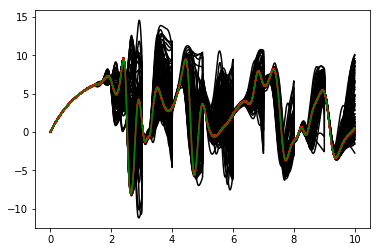

In [8]:
plt.plot(output.loc[:,'ensemble0':],'k')
plt.plot(output.loc[:,'observation'],'r')
plt.plot(output.loc[:,'truth'],'g')

plt.show()